In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)

In [3]:
# Choose copula by AIC

result_names = ['BBT_Tiingo',
                'BBT_future_Tiingo_ada', 
                'BBT_future_Tiingo_eth',
                'BBT_future_Tiingo_ltc',
                'BBT_future_Tiingo_xrp',
                'BBT_future_BITX',
                'BBT_future_BITW20', 
                'BBT_future_BITW70', 
                'BBT_future_BITW100', 
                'BBT_future_CRIX']

result_names = ['BBT_future_CRIX']

coin_names = ['btc', 'ada', 'eth', 'ltc', 'xrp',
              'BITX', 'BITW20', 'BITW70', 'BITW100', 'CRIX']

result_coin_mapper = dict(zip(result_names, coin_names))

# l = pd.read_json('../../results/BBT_future_Tiingo_ada/MM/likelihood.json') # likelihood 
l = pd.read_json('../../results/BBT_future_CRIX/MM/likelihood.json') # likelihood 
# l *= 300 # 300 data points
# l = l.iloc[[0,1,3,4,5,6,7]] #remove t copula capped

In [4]:
NIG_l = pd.read_csv('LL_NIG.csv')

NIG_l = NIG_l.iloc[:,:2]

NIG_l.columns = ['file', 'NIG']
NIG_l.iloc[:,0] = NIG_l.iloc[:,0].apply(lambda x: str(x)+'.csv')
NIG_l
# NIG_l.set_index('Unnamed: 0', )

,file,NIG
0,0.csv,472.732948
1,1.csv,477.443109
2,2.csv,474.060929
3,3.csv,480.930078
4,4.csv,495.623324
5,5.csv,491.848707
6,6.csv,493.393141
7,7.csv,498.761956
8,8.csv,501.306402
9,9.csv,500.090179


In [5]:
l = l.T.reset_index()

In [6]:
OHR = pd.read_csv('../../results/BBT_future_BITX/MM/OHR.csv')
OHR.loc[OHR.file == '18.csv',:]

,Unnamed: 0,file,risk measure,OHR,copula
240,240,18.csv,Variance,0.981055,Gaussian
241,241,18.csv,ERM k=10,0.973242,Gaussian
242,242,18.csv,ES q=0.01,0.986035,Gaussian
243,243,18.csv,ES q=0.05,0.975488,Gaussian
244,244,18.csv,VaR q=0.01,0.972070,Gaussian
245,245,18.csv,VaR q=0.05,0.960840,Gaussian
726,240,18.csv,Variance,0.977148,t_Copula
727,241,18.csv,ERM k=10,0.972168,t_Copula
728,242,18.csv,ES q=0.01,0.977734,t_Copula
729,243,18.csv,ES q=0.05,0.974219,t_Copula


In [190]:
l = l.merge(NIG_l, left_on='index', right_on='file')
l = l.loc[:,['index']+copula_names]
l = l.set_index('index').T

In [203]:
# copula_names = ['Gaussian',	't_Copula',	't_Copula_Capped', 'Clayton', 'Frank', 'Gumbel', 'Plackett', 'Gauss Mix Indep',	'NIG']
# l.loc[:,['Gaussian', 'Clayton']]

In [238]:
k = {'Gaussian':1,
     't_Copula':2, 
     't_Copula_Capped':2, 
     'Clayton':1, 
     'Frank':1, # suppress Frank
     'Gumbel':1,  
     'Plackett':1,  
     'Gauss Mix Indep':2, 
     'NIG':3}

copula_names = list(k.keys())

def AIC_table(l, drop_t_Copula_Capped=True):
    # l likelihood table
    if drop_t_Copula_Capped:
        l = l.drop(index='t_Copula_Capped')
       
    copula_names = list(l.index)
    AIC = l.copy()
    
    for c in copula_names:
        AIC.loc[c,:] = -2*l.loc[c,:]+2*k[c]
        
    return AIC

In [239]:
_AIC = AIC_table(l, True)
_copula = _AIC.idxmin(axis='rows')
_copula = pd.DataFrame(_copula).reset_index()
_copula.columns = ['file', 'copula']
copula_to_use[result] = _copula

copula_count = pd.pivot_table(_copula, index=['copula'], aggfunc='count')

In [240]:
_copula.loc[_copula.copula =='NIG']

,file,copula
14,56.csv,NIG
47,18.csv,NIG
78,9.csv,NIG


2019-10-25 20:00:00+00:00 2021-01-06 21:00:00+00:00


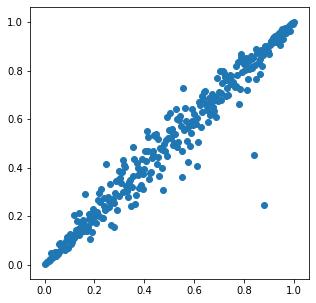

In [330]:
file = '18.csv'
rn = 'BBT_future_CRIX'
train = pd.read_csv('../../processed_data/%s/train/%s'%(rn, file))

rs = train.loc[:,'log return CRIX']
rf = train.loc[:,'log return future']

u = ECDF(rs)(rs)
v = ECDF(rf)(rf)
plt.figure(figsize=(5,5))
plt.scatter(u, v)
# plt.scatter(rs, rf)
print(train.Date.iloc[-1], train.Date.iloc[0])

Optimization terminated successfully.
         Current function value: 0.020040
         Iterations: 71
         Function evaluations: 155


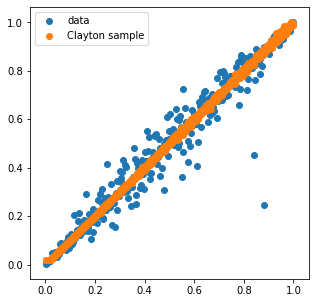

In [331]:
import copulae1
import KDEs

kde_rs = KDEs.KDE(rs, 'Gaussian')
kde_rf = KDEs.KDE(rf, 'Gaussian')

C = copulae1.Clayton({'theta':0.000001}, kde_rs, kde_rf)
C.mm_calibrate(u,v, [0.05,0.1,0.9,0.95])
# C.canonical_calibrate(u,v)


# C = copulae1.Clayton({'theta':}, kde_rs, kde_rf)

s = C.sample(1000)
plt.figure(figsize=(5,5))
plt.scatter(u, v, label='data')
plt.scatter(ECDF(s[:,0])(s[:,0]), ECDF(s[:,1])(s[:,1]),label='Clayton sample')
plt.legend()

In [357]:
q_arr = [0.05,0.1,0.9,0.95]
target = [toolbox.empirical_lambda(u, v, q) for q in q_arr] + [scipy.stats.kendalltau(rs, rf)[0]]
target

def loss(theta):
    C.theta = theta
    return np.sum((target - np.array([C._lambda(q) for q in q_arr] +[C.tau()]))**2)

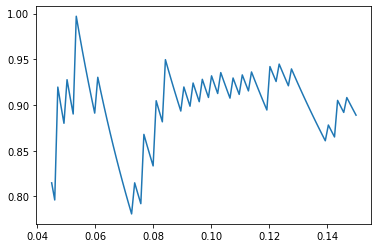

In [368]:
q_arr = np.linspace(0.045,0.15,100)

plt.plot(q_arr, [toolbox.empirical_lambda(u, v, q) for q in q_arr])

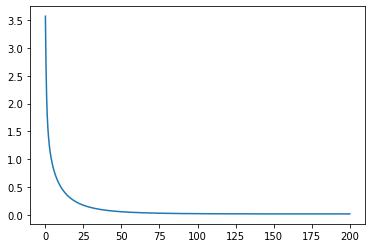

In [362]:
theta_arr = np.linspace(0.1, 200, 1000)
plt.plot(theta_arr, [loss(t) for t in theta_arr])

In [363]:
theta_arr[np.argmin([loss(t) for t in theta_arr])]

180.9904904904905

In [352]:
import toolbox
loss(10)



array([9.02051947e-08, 9.02051919e-08, 1.93850196e-01, 3.17703047e-01,
       2.62448612e-03])

In [339]:
import scipy
scipy.stats.kendalltau(rs, rf)

KendalltauResult(correlation=0.8845630719726645, pvalue=1.5728608628138706e-115)

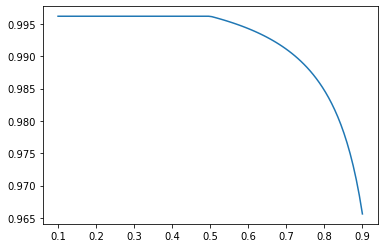

In [326]:
q_arr = np.linspace(0.1,.9,100)
plt.plot(q_arr, [C._lambda(q) for q in q_arr])

Optimization terminated successfully.
         Current function value: 0.007662
         Iterations: 41
         Function evaluations: 89


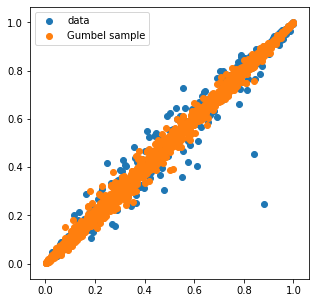

In [323]:
kde_rs = KDEs.KDE(rs, 'Gaussian')
kde_rf = KDEs.KDE(rf, 'Gaussian')

C = copulae1.Gumbel({'theta':10}, kde_rs, kde_rf)
C.mm_calibrate(u,v, [0.05,0.1,0.9,0.95])
# C.canonical_calibrate(u,v)

s = C.sample(1000)

plt.figure(figsize=(5,5))
plt.scatter(u, v, label='data')
plt.scatter(ECDF(s[:,0])(s[:,0]), ECDF(s[:,1])(s[:,1]), label='Gumbel sample')
plt.legend()

Optimization terminated successfully.
         Current function value: -535.654961
         Iterations: 106
         Function evaluations: 215


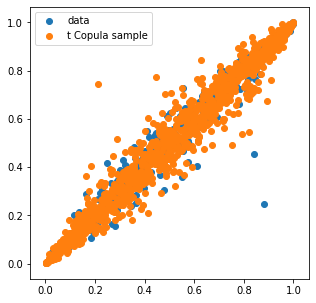

In [300]:
kde_rs = KDEs.KDE(rs, 'Gaussian')
kde_rf = KDEs.KDE(rf, 'Gaussian')

C = copulae1.t_Copula({'rho':0.5, 'nu':4}, kde_rs, kde_rf, 2)
# C.mm_calibrate(u,v, [0.05,0.1,0.9,0.95])
C.canonical_calibrate(u,v)

s = C.sample(1000)

plt.figure(figsize=(5,5))
plt.scatter(u, v, label='data')
plt.scatter(ECDF(s[:,0])(s[:,0]), ECDF(s[:,1])(s[:,1]), label='t Copula sample')
plt.legend()

In [225]:
h = np.corrcoef(rs, rf)[0,1]*np.std(rs)/np.std(rf)
h

0.9639460203806471

In [243]:
copula_count

,file
copula,
Gauss Mix Indep,24
NIG,3
t_Copula,61


In [246]:
l.to_html('LL_withNIG_Crix.html')

In [152]:
AIC_results = dict()
copula_to_use = dict()
copula_count = dict()

for result in result_names:
    l = pd.read_json('../../results/%s/MM/likelihood.json'%result) # likelihood 
    l *=300 # 300 data points
    
    _AIC = AIC_table(l, True)
    AIC_results[result] = _AIC
    
    _copula = _AIC.idxmin(axis='rows')
    _copula = pd.DataFrame(_copula).reset_index()
    _copula.columns = ['file', 'copula']
    copula_to_use[result] = _copula
    

    copula_count[result]= pd.pivot_table(_copula, index=['copula'], aggfunc='count')

In [153]:
copula_count_summary = pd.DataFrame(columns=copula_names)

for rm in result_names:
    c = copula_count[rm]
    c.index.name = None
    c.columns = [result_coin_mapper[rm]]
    copula_count_summary = copula_count_summary.append(c.T)

In [154]:
copula_count_summary = copula_count_summary.fillna(0)


In [155]:
copula_count_summary = pd.concat([copula_count_summary.loc[:,c] for c in copula_names if c != 't_Copula_Capped'],
          axis=1)

In [156]:
copula_count_summary.loc['sum',:] = copula_count_summary.sum()

In [157]:
copula_count_summary = copula_count_summary.astype(np.int)
# _index = ['btc','eth','ada','ltc','xrp','BITX','CRIX','BITW100','BITW20','BITW70']

# copula_count_summary.reindex(_index)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [158]:
_index = ['btc','eth','ada','ltc','xrp','BITX','CRIX','BITW100','BITW20','BITW70']
copula_count_summary.reindex(_index)

,Gaussian,t_Copula,Clayton,Frank,Gumbel,Plackett,Gauss Mix Indep
btc,0,105,0,6,0,1,0
eth,3,56,1,0,0,18,34
ada,3,77,12,0,0,0,15
ltc,0,82,6,0,0,0,24
xrp,1,25,47,0,0,37,2
BITX,0,57,0,0,0,0,24
CRIX,0,63,0,0,0,0,25
BITW100,0,61,0,0,0,0,20
BITW20,0,60,2,0,0,1,18
BITW70,0,47,34,0,0,0,0


'2020-12-11 21:00:00+00:00'

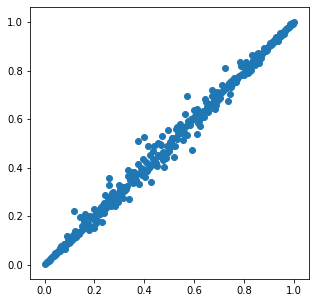

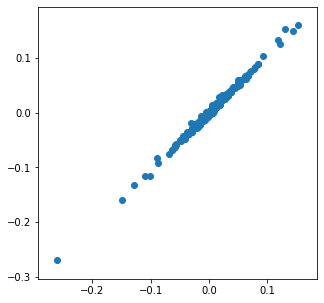

In [99]:
df = pd.read_csv('../../processed_data/BBT_Tiingo/train/22.csv')

rs = df.loc[:,'log return bitcoin']
rf = df.loc[:,'log return future']

import matplotlib.pyplot as plt
import os, sys
sys.path.append('../../src/')
import toolbox
import KDEs as K

kde_rs = K.KDE(rs, 'Gaussian')
kde_rf = K.KDE(rf, 'Gaussian')

u = kde_rs.cdf(rs)
v = kde_rf.cdf(rf)
plt.figure(figsize=(5,5))
plt.scatter(u, v)

plt.figure(figsize=(5,5))
plt.scatter(rs, rf)
df.Date.iloc[0]

In [100]:
copula_to_use[result_names[0]]

,file,copula
0,97.csv,t_Copula
1,83.csv,t_Copula
2,68.csv,t_Copula
3,6.csv,t_Copula
4,54.csv,t_Copula
5,40.csv,Gauss Mix Indep
6,41.csv,t_Copula
7,7.csv,t_Copula
8,55.csv,t_Copula
9,69.csv,t_Copula


In [101]:
OHR = pd.read_csv('../../results/%s/MM/OHR.csv'%result_names[0])

In [102]:
risk_measures = list(np.unique(OHR.loc[:, 'risk measure']))

In [103]:
for rn in result_names:
    for rm in risk_measures:
        ctu = copula_to_use[rn]
        rh_df = pd.DataFrame()

        for i in range(len(ctu)):
            file = ctu.file[i]
            c = ctu.copula[i]

            _id = (OHR.file==file) & (OHR.copula==c) & (OHR.loc[:,'risk measure']==rm)
            h = OHR.loc[_id,'OHR'].values[0]

            # Load testing data
            test_df = pd.read_csv('../../processed_data/%s/test/%s'%(rn, file))

            Date = test_df.Date
            rs = test_df.iloc[:,-1]
            rf = test_df.iloc[:,-2]
            rh = rs - h*rf

            rh = pd.DataFrame({'Date':Date, 'rh':rh, 'rs':rs, 'rf':rf, 'h':h, 'copula':c})
            rh_df = rh_df.append(rh)

        rh_df.Date = pd.to_datetime(rh_df.Date)
        rh_df.sort_values('Date', ascending=False, inplace=True)
        rh_df.to_csv('../../results/%s/MM/rh_%s_copula_selection.csv'%(rn, rm))

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


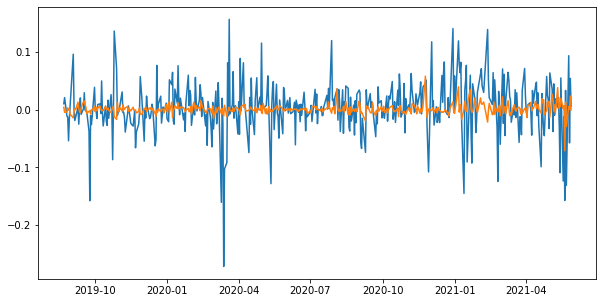

In [104]:
plt.figure(figsize=(10,5))
plt.plot(rh_df.Date, rh_df.rs)
plt.plot(rh_df.Date, rh_df.rh)

In [105]:
rh_df

,Date,rh,rs,rf,h,copula
0,2021-05-27 20:00:00+00:00,-5.869838e-04,0.005573,0.006583,0.935742,t_Copula
1,2021-05-26 20:00:00+00:00,2.346679e-02,0.054012,0.032643,0.935742,t_Copula
2,2021-05-25 20:00:00+00:00,6.191337e-04,-0.057626,-0.062245,0.935742,t_Copula
3,2021-05-24 20:00:00+00:00,5.002155e-03,0.093271,0.094330,0.935742,t_Copula
4,2021-05-21 20:00:00+00:00,-2.935953e-02,-0.131176,-0.108809,0.935742,t_Copula
0,2021-05-20 20:00:00+00:00,1.305516e-02,0.033315,0.021291,0.951562,Gauss Mix Indep
1,2021-05-19 20:00:00+00:00,-7.121014e-02,-0.157294,-0.090465,0.951562,Gauss Mix Indep
2,2021-05-18 20:00:00+00:00,6.672540e-03,-0.012067,-0.019694,0.951562,Gauss Mix Indep
3,2021-05-17 20:00:00+00:00,1.734805e-03,-0.123533,-0.131645,0.951562,Gauss Mix Indep
4,2021-05-14 20:00:00+00:00,1.969524e-02,0.054760,0.036850,0.951562,Gauss Mix Indep


In [139]:
name = 'BBT_future_Tiingo_xrp'
copula_to_use[name]

train = pd.read_csv('../../processed_data/%s/train/%s'%(name, '0.csv'))

train.head()

,Unnamed: 0,Date,PX_LAST,contract_name,xrp Price,log return future,log return xrp
0,5,2021-05-20 20:00:00+00:00,40350.0,BTCM1 Curncy,1.182123,0.021291,0.014197
1,6,2021-05-19 20:00:00+00:00,39500.0,BTCM1 Curncy,1.165459,-0.090465,-0.304108
2,7,2021-05-18 20:00:00+00:00,43240.0,BTCM1 Curncy,1.579682,-0.019694,0.031345
3,8,2021-05-17 20:00:00+00:00,44100.0,BTCM1 Curncy,1.530934,-0.131645,0.102715
4,9,2021-05-14 20:00:00+00:00,50305.0,BTCM1 Curncy,1.381491,0.036850,0.093586


In [140]:
# name = 'BBT_future_BITW70'
# ctu = copula_to_use[name]
# ctu.head()

In [141]:
training_Clayton = pd.DataFrame()
training = pd.DataFrame()
for i in range(len(ctu)):
    row = ctu.iloc[i, :]
    file = row.file
    df = pd.read_csv('../../processed_data/%s/train/%s'%(name, file))
    training = training.append(df)
    if row.copula == 'Clayton':
        training_Clayton = training_Clayton.append(df)
        
training_Clayton = training_Clayton.drop_duplicates('Date')
training_Clayton.Date = pd.to_datetime(training_Clayton.Date)
training_Clayton.sort_values('Date', inplace=True)

training = training.drop_duplicates('Date')
training.Date = pd.to_datetime(training.Date)
training.sort_values('Date', inplace=True)

In [142]:
training

,Unnamed: 0,Date,PX_LAST,contract_name,xrp Price,log return future,log return xrp
299,704,2018-08-13 20:00:00+00:00,6230.0,BTCU18 Curncy,0.279634,-0.026140,-0.171384
298,703,2018-08-14 20:00:00+00:00,6075.0,BTCU18 Curncy,0.264003,-0.025194,-0.057522
297,702,2018-08-15 20:00:00+00:00,6370.0,BTCU18 Curncy,0.285980,0.047417,0.079961
296,701,2018-08-16 20:00:00+00:00,6410.0,BTCU18 Curncy,0.296846,0.006260,0.037294
295,700,2018-08-17 20:00:00+00:00,6480.0,BTCU18 Curncy,0.336140,0.010861,0.124313
294,699,2018-08-20 20:00:00+00:00,6430.0,BTCU18 Curncy,0.335104,-0.007746,-0.003086
293,698,2018-08-21 20:00:00+00:00,6420.0,BTCU18 Curncy,0.328571,-0.001556,-0.019688
292,697,2018-08-22 20:00:00+00:00,6405.0,BTCU18 Curncy,0.319223,-0.002339,-0.028863
291,696,2018-08-23 20:00:00+00:00,6395.0,BTCU18 Curncy,0.318867,-0.001563,-0.001115
290,695,2018-08-24 20:00:00+00:00,6595.0,BTCU18 Curncy,0.323968,0.030795,0.015871


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


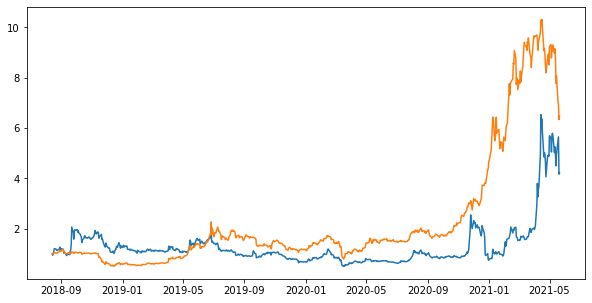

In [144]:
future = training.loc[:,'PX_LAST']
# spot = training.loc[:,'BITW70 Price']

spot = training.loc[:,'xrp Price']
date = training.Date

plt.figure(figsize=(10,5))
plt.plot(date, spot/spot.iloc[0])
plt.plot(date, future/future.iloc[0])

# plt.plot(training_Clayton.Date, training_Clayton.loc[:, 'xrp Price']/xrp.iloc[-1])
# plt.plot(date, future/future.iloc[-1])

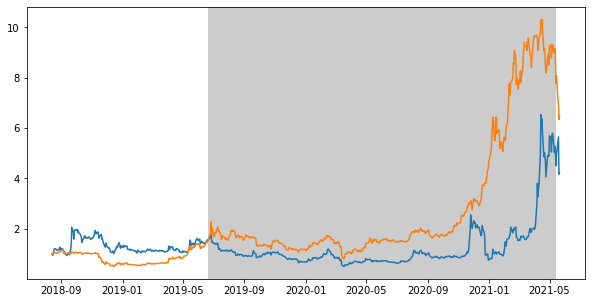

In [145]:
plt.figure(figsize=(10,5))
plt.plot(date, spot/spot.iloc[0])
plt.plot(date, future/future.iloc[0])

_start = training_Clayton.Date.iloc[0]
_end = 0
for i in range(len(training_Clayton)-1):
    start = training_Clayton.Date.iloc[i]
    end =  training_Clayton.Date.iloc[i+1]
    _end = end
    plt.axvspan(start, end,facecolor='black', alpha=.2)

In [146]:
_start

Timestamp('2019-06-20 20:00:00+0000', tz='UTC')

In [147]:
_end

Timestamp('2021-05-13 20:00:00+0000', tz='UTC')

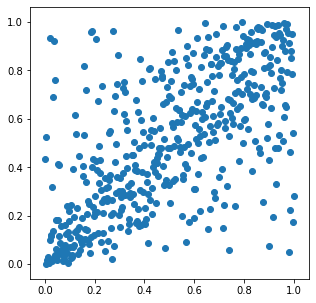

In [148]:
# rs = train.loc[:,'log return xrp']
# rf = train.loc[:,'log return future']
rs = np.array(training_Clayton.iloc[:, -1])
rf = np.array(training_Clayton.iloc[:, -2])

kde_rs = K.KDE(rs, 'Gaussian')
kde_rf = K.KDE(rf, 'Gaussian')

u = kde_rs.cdf(rs)
v = kde_rf.cdf(rf)

plt.figure(figsize=(5,5))
plt.scatter(u,v)